# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка необходимых библиотек

In [1]:
!pip install wordcloud==1.8.2.2  -q

In [2]:
!pip install --upgrade Pillow==9.5.0 -q

In [3]:
import pandas as pd
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import re
import os
import string
from scipy.stats import randint, uniform
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Загрузка и изучение данных

In [5]:
try:
    toxic = pd.read_csv('C:/Users/79041/Downloads/toxic_comments.csv', index_col=0)
except:
    toxic = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [6]:
toxic.head(20)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [7]:
toxic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Мы видим, что нет пропусков в данных и Текст на английском языке. 

Изучим баланс классов в целевом признаке.

In [8]:
toxic['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Мы видим, что соотношение примерно 90%/10%, это значит что имеется дисбаланс классов

### Лемматизация текстов

Для обработки текстов моделью нужно привести исходные тексты к Леммам (т.е. начальным формам слова). 

Так как лемматизация текстов может длиться продолжительное время, создадим тестовый датафрейм для проверки работы функции.

In [9]:
sentence1 = "The striped @ bats //are hanging on their feet for best"
sentence2 = "you should be. ashamed of yourself!went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

                                                text
0  The striped @ bats //are hanging on their feet...
1     you should be. ashamed of yourself!went worked


Задаем объект лемматизации, список стоп-слов и знаков пунктуации

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punct = set(string.punctuation)

Напишем функцию, которая преобразует pos-теги в подходящий формат для работы с библиотекой nltk.

In [11]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Далее пишем функцию лемматизиции текстов с предобработкой, токенизацией и pos-тэгингом

In [12]:
def preprocess_text(text):
    # 1. Приведение к нижнему регистру
    text = text.lower()
      
    # 2. Удаление чисел
    text = re.sub(r'\d+', '', text)
    
    # 3. Удаление специальных символов и лишних пробелов
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 4. Токенизация
    tokens = word_tokenize(text)
    
    # 5. Удаление стоп-слов и пунктуации
    tokens = [word for word in tokens 
              if word not in stop_words and word not in punct]
    
    # 6. POS-тэгинг
    pos_tags = pos_tag(tokens)
    
    # 7. Лемматизация с учетом части речи
    lemmatized = []
    for word, tag in pos_tags:
        wn_pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=wn_pos)
        lemmatized.append(lemma)
    
    # 8. Фильтрация коротких слов (длина < 2)
    lemmatized = [word for word in lemmatized if len(word) > 1]
    
    return ' '.join(lemmatized)

Проверим работу функции на тестовом датасете:

In [13]:
df_my['cleaned_text'] = df_my['text'].apply(preprocess_text)

In [14]:
print("Оригинальный текст vs Очищенный текст:")
for orig, clean in zip(df_my['text'].head(), df_my['cleaned_text'].head()):
    print(f"\nOriginal: {orig}\nCleaned: {clean}\n{'-'*50}")

Оригинальный текст vs Очищенный текст:

Original: The striped @ bats //are hanging on their feet for best
Cleaned: strip bat hang foot best
--------------------------------------------------

Original: you should be. ashamed of yourself!went worked
Cleaned: ashamed go worked
--------------------------------------------------


Мы видим, что текст отчищен от лишних знаков и слов. Слова приведены к леммам.

Применим функцию к рабочему датасету.

In [15]:
toxic['cleaned_text'] = toxic['text'].apply(preprocess_text)

In [16]:
print("Оригинальный текст vs Очищенный текст:")
for orig, clean in zip(toxic['text'].head(), toxic['cleaned_text'].head()):
    print(f"\nOriginal: {orig}\nCleaned: {clean}\n{'-'*50}")

Оригинальный текст vs Очищенный текст:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned: explanation edits make username hardcore metallica fan revert vandalisms closure gas vote new york doll fac please remove template talk page since retire
--------------------------------------------------

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned: aww match background colour seemingly stuck thanks talk january utc
--------------------------------------------------

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatt

Мы видим, что тексты преобразовавны верно.

### Визуализации облака слов для заданных текстов:

Для изучения информации в предоставленных текстах построим график "облако слов".

Соберем все тексты в один большой для получения возможности обработки текстов.

In [17]:
all_text = ' '.join(toxic['text'].astype(str))

Создаем объект с необходимым шрифтом

In [18]:
font_path = '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'

Генерируем облако слов и выводим на графике.

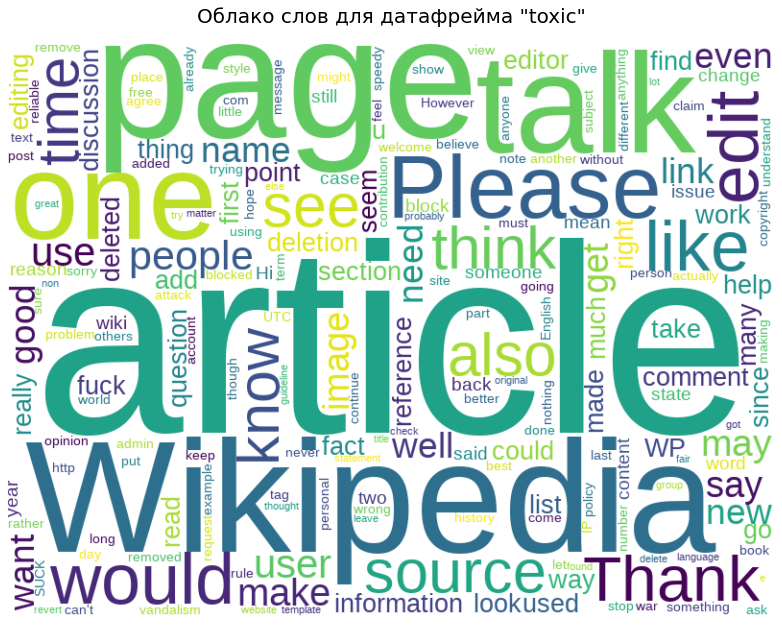

In [19]:
wordcloud = WordCloud(
    width=800, 
    height=600,
    background_color='white',
    stopwords=stop_words,
    min_font_size=10,
    max_words=200,
    font_path = font_path,
    collocations=False
).generate(all_text)


plt.figure(figsize=(12, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Облако слов для датафрейма "toxic"', fontsize=20, pad=20)
plt.show()

Судя по самым популярным словам, в текстах идёт речь в основном про статьи онлайн-энциклопедии Википедия. Вероятно мы имеем дело с отзывами к статьям. Из положительного можно отметить, что не видно крупных негативно окрашенных слов. 

## Обучение

Разбиваем данные на обучающие и тестовые выборки.

In [20]:
X = toxic['cleaned_text']
y = toxic['toxic']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train) 
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

Подготавливаем модель логистической регрессии:

In [22]:
model_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=100_000,          
        ngram_range=(1, 3),            # Учитываем триграммы
        stop_words='english',          # Удаление стоп-слов
        sublinear_tf=True,             # Сглаживание частот
        min_df=5,                      # Игнорировать редкие слова
        max_df=0.9                     # Игнорировать слишком частые слова
    )),
    ('clf', LogisticRegression(
        class_weight='balanced',
        solver='saga',                 # Лучше для больших данных
        penalty='elasticnet',          # L1 + L2 регуляризация
        l1_ratio=0.5,                 # Баланс между L1 и L2
        max_iter=200,                 
        n_jobs=-1,
        random_state = 42
    ))
])

Обучаем модель

In [23]:
model_lr.fit(X_train, y_train)


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=100000, min_df=5,
                                 ngram_range=(1, 3), stop_words='english',
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                    max_iter=200, n_jobs=-1,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

Получаем предсказания на валидационной выборке:

In [24]:
preds_lr = model_lr.predict(X_val)
print(f"F1 score: {f1_score(y_val, preds_lr):.4f}")

F1 score: 0.7686


Треуемая метрика (0.75) yполучена, модель подходит для работы.

Подготовим модель регрессии основанной на градиентном спуске.

In [25]:
model_sgd = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100_000, ngram_range=(1, 3))),
    ('clf', SGDClassifier(
        loss='modified_huber', 
        class_weight='balanced',
        max_iter=500,
        n_jobs=-1,
        random_state=42
    ))
])

In [26]:
param_dist = {
    'clf__alpha': uniform(1e-6, 1e-3),
    'clf__penalty': ['l2', 'l1', 'elasticnet'],
    'clf__l1_ratio': uniform(0, 1),
    'clf__epsilon': uniform(0.05, 0.2),
    'tfidf__max_features': randint(50_000, 100_000)}

In [27]:
f1_scorer = make_scorer(f1_score)

In [28]:
random_search = RandomizedSearchCV(
    estimator=model_sgd,
    param_distributions=param_dist,
    n_iter=15,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [29]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_features=100000,
                                                              ngram_range=(1,
                                                                           3))),
                                             ('clf',
                                              SGDClassifier(class_weight='balanced',
                                                            loss='modified_huber',
                                                            max_iter=500,
                                                            n_jobs=-1,
                                                            random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'clf__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff5ed...
                                        'clf__epsilon': <s

In [30]:
best_model = random_search.best_estimator_

In [31]:
y_val_pred = best_model.predict(X_val)

In [32]:
val_f1 = f1_score(y_val, y_val_pred)

print(f"F1-score на валидационной выборке: {val_f1:.4f}")

F1-score на валидационной выборке: 0.7506


Метрика выше требуемой, но ниже, чем у модели логистической регрессии..

## Тестирование модели

Для тестирования выбираем модель логистической регрессии, т.к. ее метрика выше на валидационной выборке.

In [33]:
preds_lr = model_lr.predict(X_test)
print(f"F1 score: {f1_score(y_test, preds_lr):.4f}")

F1 score: 0.7792


## Итоговый вывод 

В течение проекта мы выполнили следующие шаги:
- Изучили предоставленные данные и удалили лишние;
- Изучили распределение целевого признака;
- Произвели очистку и лемматизацию текстов;
- Изучили содержание тестов с помощью графика "Облако слов".
- Подготовили две модели бинарной классификации:
     * Модель логистической регрессии: получена метрика на валидации F1 score: 0.7686;
     * Модель градиентного бустинга SGDClassifier: получена метрика на валидации F1 score: 0.7506
- Проверили результат работы модели на тестовоый выборке. Получена метрика F1 score: 0.7792;
<br>**По итогам сравнения выбрана модель *логистической регрессии*, так полученная метрика на тесте соответствует заявленой (требование F1 score >= 0.75)**










###### 